In [22]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from copy import deepcopy

import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams["figure.facecolor"] = '#ffffff'

In [2]:
## Import some R functions for calculating confidence intervales of Poisson ratios

from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
exactci = importr("exactci")

def calc_95_CI(X1, X2, N1, N2):
    CI = exactci.poisson_exact(FloatVector([X1, X2]), FloatVector([N1, N2]))
    return float(CI[4][0]), list(CI[3])

def calc_95_CI_single(X1, N1):
    CI = exactci.poisson_exact(float(X1), float(N1))
    return float(CI[4][0]), list(CI[3])

In [21]:
mu_scaled = pd.read_csv("mu_vals")
mu_scaled.head()

,mu
0,1.319267e-09
1,2.029641e-09
2,3.044462e-09
3,4.160764e-09
4,5.175585e-09


In [18]:
mu_vals = np.sort(np.array(list(set(mu_scaled.mu))))
mu_vals[0:19]

array([1.31926670e-09, 2.02964108e-09, 3.04446162e-09, 4.16076421e-09,
       5.17558475e-09, 6.29188735e-09, 7.40818994e-09, 8.42301048e-09,
       9.53931308e-09, 1.06556157e-08, 1.18734003e-08, 1.29897029e-08,
       1.41060055e-08, 1.53237902e-08, 1.65415748e-08, 1.76578774e-08,
       1.88756620e-08, 2.00934467e-08, 2.14127134e-08])

In [5]:
data_roulette = pd.read_csv("variance_roulette", delim_whitespace=True)
data_roulette = data_roulette[~np.isnan(data_roulette.rate_SNV_div_rate_no_SNV)].reset_index()
data_roulette.head()

,index,predicted_rate,number_of_mutations_no_SNV,number_of_sites_no_SNV,number_of_mutations_SNV,number_of_sites_SNV,rate_SNV_div_rate_no_SNV
0,1,0.013,3642,455867042,57,5552885,1.284856
1,2,0.020,17711,1407704153,490,27363779,1.423273
2,3,0.030,19607,1058844151,785,30520404,1.388994
3,4,0.041,17611,703786249,895,27449664,1.302995
4,5,0.051,16133,510324931,1050,25310121,1.312281


In [6]:
data_gnomad = pd.read_csv("variance_GNOMAD", delim_whitespace=True)
data_gnomad = data_gnomad[~np.isnan(data_gnomad.rate_SNV_div_rate_no_SNV)].reset_index()
data_gnomad.head()

,index,predicted_rate,number_of_mutations_no_SNV,number_of_sites_no_SNV,number_of_mutations_SNV,number_of_sites_SNV,rate_SNV_div_rate_no_SNV
0,0,0.0173,1811,169751508,88,2797198,2.948863
1,1,0.0174,855,86874904,21,1473846,1.447756
2,2,0.0177,1136,91033662,14,1569202,0.714945
3,3,0.0178,978,92534248,35,1602379,2.066648
4,4,0.0201,675,52362964,14,990179,1.096819


In [7]:
data_carlson = pd.read_csv("variance_carlson", delim_whitespace=True)
data_carlson = data_carlson[~np.isnan(data_carlson.rate_SNV_div_rate_no_SNV)].reset_index()
data_carlson.head()

,index,predicted_rate,number_of_mutations_no_SNV,number_of_sites_no_SNV,number_of_mutations_SNV,number_of_sites_SNV,rate_SNV_div_rate_no_SNV
0,0,0.5,4462,495584761,106,7226721,1.629120
1,1,1.5,23585,1572883983,867,37385435,1.546598
2,2,2.5,22741,931669173,1321,35945662,1.505596
3,3,3.5,18149,535188167,1458,29382870,1.463245
4,4,4.5,16634,372789034,1658,26733251,1.389950


In [8]:
def add_estimates(data_mut):
    nbins = data_mut.shape[0]
    total_sites = data_mut.number_of_sites_no_SNV + data_mut.number_of_sites_SNV
    total_muts = data_mut.number_of_mutations_no_SNV + data_mut.number_of_mutations_SNV
    data_mut["total_sites"] = total_sites
    data_mut["total_muts"] = total_muts
    
    mu_ests, mu_upper_CI, mu_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    ratio_ests, ratio_upper_CI, ratio_lower_CI = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
    for ii in range(nbins):
        mu_est = calc_95_CI_single(total_muts[ii], total_sites[ii])
        mu_ests[ii] = mu_est[0]
        mu_lower_CI[ii] = mu_est[1][0]
        mu_upper_CI[ii] = mu_est[1][1]
        
        ratio_est = calc_95_CI(data_mut.number_of_mutations_SNV[ii], data_mut.number_of_mutations_no_SNV[ii], 
                               data_mut.number_of_sites_SNV[ii], data_mut.number_of_sites_no_SNV[ii])
        ratio_ests[ii] = ratio_est[0]
        ratio_lower_CI[ii] = ratio_est[1][0]
        ratio_upper_CI[ii] = ratio_est[1][1]
        
        
    data_mut["mu_est"] = mu_ests
    data_mut["mu_95CI_lower"] = mu_lower_CI
    data_mut["mu_95CI_upper"] = mu_upper_CI
    
    data_mut["ratio_est"] = ratio_ests
    data_mut["ratio_95CI_lower"] = ratio_lower_CI
    data_mut["ratio_95CI_upper"] = ratio_upper_CI
    
    data_mut["prop_poly"] = data_mut.number_of_sites_SNV / data_mut.total_sites

In [9]:
add_estimates(data_roulette)
add_estimates(data_gnomad)
add_estimates(data_carlson)

We need to scale the mutation rate estimates to per-generation units since we don't yet know the number of trios or total amount of genomic sequence considered in the compiled experiments. A quick hack is to compare to per-generation values given by Vova.

In [20]:
import scipy.optimize as optim
optim.curve_fit(lambda A, mu_est : A*mu_est, mu_vals, data_roulette.mu_est, 1e6)

(array([7181.51292331]), array([[2570.31222842]]))

In [113]:
mu_scale = 1/7181.51292331

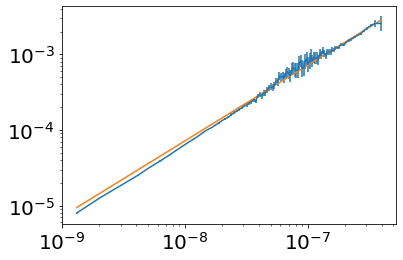

In [109]:
plt.errorbar(mu_vals, data_roulette.mu_est, 
             yerr=[data_roulette.mu_est - data_roulette.mu_95CI_lower, 
                   data_roulette.mu_95CI_upper - data_roulette.mu_est])
plt.plot(mu_vals, mu_vals*7181)
plt.yscale("log")
plt.xscale("log")

The approach we will use to esimate the residual variance within mutation rate bins is to separate potential mutations by whether an SNV appears in gnomAD v3 or not. These two categories are then compared in de novo mutation data. If the potential mutations with observed SNVs have a higher rate of de novo mutation within a given bin, then there must be some residual mutation rate variation within that bin.

As a statistic, we used the observed de novo mutation rate ratio between SNV and non-SNV positions.

In [61]:
from matplotlib import cm
c_roulette = cm.get_cmap("tab10")(0)
c_carlson = cm.get_cmap("tab10")(1)
c_gnomad = cm.get_cmap("tab10")(2)

In [64]:
def plot_ratios(data_mut, ax, color="black", alpha=0.8, alpha_ebar=0.3, label=None):
    ax.scatter(data_mut.prop_poly, data_mut.ratio_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.prop_poly, data_mut.ratio_est, 
                yerr=[data_mut.ratio_est - data_mut.ratio_95CI_lower, 
                      data_mut.ratio_95CI_upper - data_mut.ratio_est], fmt="none", color=color, alpha=alpha_ebar)

In [124]:
def plot_mu_ratios(data_mut, ax, color="black", alpha=0.8, alpha_ebar=0.3, label=None, mu_scale=mu_scale):
    ax.scatter(data_mut.mu_est*mu_scale, data_mut.ratio_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.ratio_est, 
                yerr=[data_mut.ratio_est - data_mut.ratio_95CI_lower, 
                      data_mut.ratio_95CI_upper - data_mut.ratio_est], fmt="none", color=color, alpha=alpha_ebar)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.ratio_est, 
                xerr=[data_mut.mu_est*mu_scale - data_mut.mu_95CI_lower*mu_scale, 
                      data_mut.mu_95CI_upper*mu_scale - data_mut.mu_est*mu_scale], fmt="none", color=color, alpha=alpha_ebar)

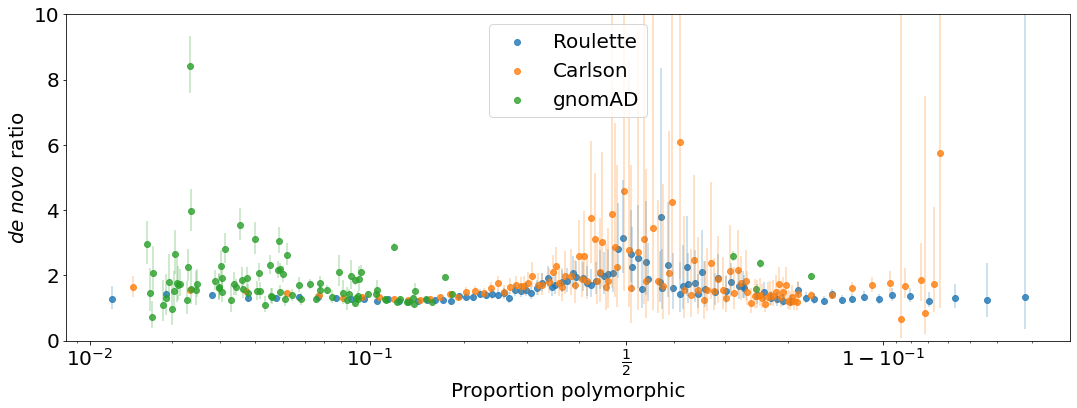

In [92]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_ratios(data_roulette, ax, alpha=0.8, color=c_roulette, label="Roulette")
plot_ratios(data_carlson, ax, alpha=0.8, color=c_carlson, label="Carlson")
plot_ratios(data_gnomad, ax, alpha=0.8, color=c_gnomad, label="gnomAD")
ax.set_xscale("logit")
ax.set_ylim([0,10])
ax.set_ylabel(r"$\it{de {}_ novo}$ ratio")
ax.set_xlabel("Proportion polymorphic")
ax.legend(loc="upper center")

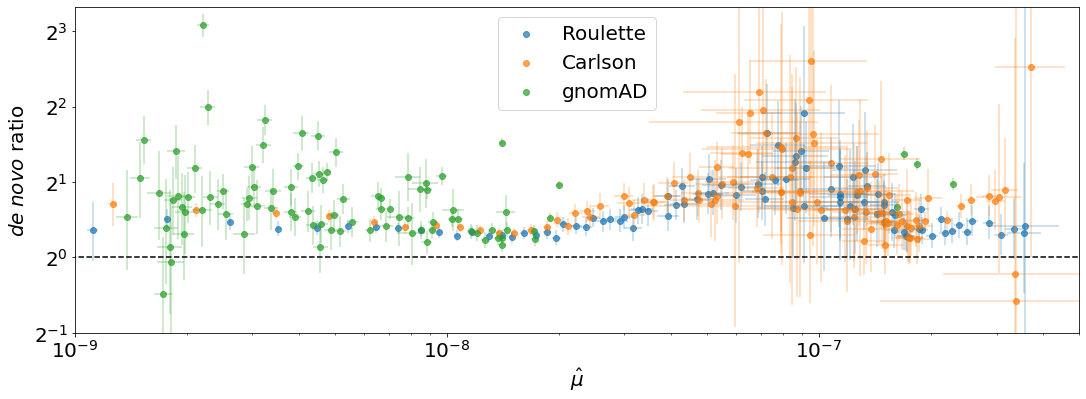

In [497]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_mu_ratios(data_roulette, ax, alpha=0.7, color=c_roulette, label="Roulette")
plot_mu_ratios(data_carlson, ax, alpha=0.7, color=c_carlson, label="Carlson")
plot_mu_ratios(data_gnomad, ax, alpha=0.7, color=c_gnomad, label="gnomAD")
ax.plot([.5e-9, 5e-7], [1,1], "--", color="black")
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=2)
ax.set_xlim([1e-9,5e-7])
ax.set_ylim([0.5,10])
ax.set_ylabel(r"$\it{de {}_ novo}$ ratio")
ax.set_xlabel(r"$\hat{\mu}$")
ax.legend(loc="upper center")
fig.savefig("de_novo_ratio.pdf", bbox_inches="tight")

How can we use de novo ratios to estimate the residual mutation rate variance within each bin? Assume that the mutation rate distribution within a bin is $f(\mu)$. We condition on whether or not an SNV is observed in the population data. If no SNV is observed the conditional distribution of mutation rates is 
$$
f(\mu|\text{no SNV}) = \frac{p(\text{no SNV}|\mu)f(\mu)}{p(\text{no SNV})}.
$$
The probability of not observing an SNV, conditional on $\mu$, is approximately $e^{-\mu T_{\text{total}}}$. This approximation will be good when the sample size is large enough that $T_{\text{total}}$ is close to constant across positions in the genome. The expected mutation count in de novo data is proportional to the average rate in a group of sites: 
$$
E[\mu|\text{no SNV}] = \int \mu f(\mu|\text{no SNV}) d\mu = \frac{\int \mu e^{-\mu T_{\text{total}}} f(\mu) d\mu}{\int e^{-\mu T_{\text{total}}} f(\mu) d\mu}.
$$
Alternatively, for mutations which are actually observed in the sample, the average mutation rate is
$$
E[\mu|\text{SNV}] = \int \mu f(\mu|\text{SNV}) d\mu = \frac{\int \mu (1-e^{-\mu T_{\text{total}}}) f(\mu) d\mu}{\int (1-e^{-\mu T_{\text{total}}}) f(\mu) d\mu}.
$$
The de novo ratio is 
$$
\frac{E[\mu|\text{SNV}]}{E[\mu|\text{no SNV}]}= \frac{E[\mu]-E[\mu e^{-\mu T_{\text{total}}}]}{E[\mu e^{-\mu T_{\text{total}}}]} 
\frac{E[e^{-\mu T_{\text{total}}}]}{1-E[e^{-\mu T_{\text{total}}}]}.
$$
When $\mu T_{\text{total}}$ is small this ratio depends only on the first two moments of the mutation rate distribution, but when the probability of observing an SNV becomes large, higher moments of $f(\mu)$ need to be considered.


In our data the proportion of polymorphic positions is upwards of $0.9$ for high mutation rates, so we must choose a probability distribution for $f(\mu)$. Though other choices are defensible, it seems reasonable to choose a lognormal distribution for $\mu$ within each bin. This assumption means that fold-changes in mutation rate within a bin are normally distributed, and avoids negative rates. Since the mean mutation rate is known, $f(\mu|\sigma)$ is parameterized by the standard deviation of rates on a log scale. Since there is not a closed-form expression for $E[\mu e^{-\mu T_{\text{total}}}]$ when $\mu$ is lognormal, we will need to use Monte-Carlo or numerical integration to calculate these expectations.


In the data, we observe the proportion polymorphic as well as the de novo ratio. This should provide two degress of freedom for estimating $\sigma$ and $T_{\text{total}}$. $T_{\text{total}}$ should be shared across mutation rate bins because it is a property of the underlying genealogy. For now we will estimate it separately for each bin and hope that it does not vary too much.

We are going to choose a grid on $\sigma$ and $T_{\text{total}}$ and for each estimated $\mu$ calculate the de novo ratio and the expected proportion polymorphic.

In [131]:
## Choose T_total values to give a reasonable range of proportion polymorphic across the range of mutation rates.

TT_min = -np.log(1-1e-3)/np.min(mu_vals)
TT_max = -np.log(1-0.999)/np.max(mu_vals)
TT_min, TT_max, np.log10(TT_min), np.log10(TT_max), 1-np.exp(-np.max(mu_vals)*TT_min), 1-np.exp(-np.min(mu_vals)*TT_max)

(758376.0979237801,
 17399983.98395875,
 5.879884636693682,
 7.240548848530787,
 0.2599767237187809,
 0.02269375292990683)

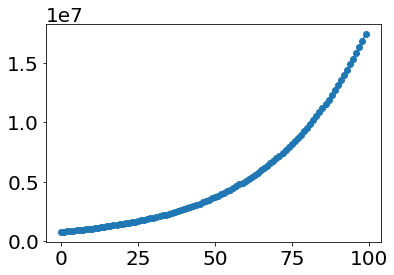

In [134]:
TT_set = np.logspace(np.log10(TT_min), np.log10(TT_max), 100, base=10)
plt.plot(TT_set, "-o")

In [138]:
## Guess what a reasonable range of standard deviations would be
sigma_set = np.linspace(0.001, 2, 200)
sigma_set[0:20]

array([0.001     , 0.01104523, 0.02109045, 0.03113568, 0.0411809 ,
       0.05122613, 0.06127136, 0.07131658, 0.08136181, 0.09140704,
       0.10145226, 0.11149749, 0.12154271, 0.13158794, 0.14163317,
       0.15167839, 0.16172362, 0.17176884, 0.18181407, 0.1918593 ])

For model fitting calculate the de novo ratio and polymorphism probability for each combination of $\sigma$ and $T_{\text{total}}$.

In [164]:
def prob_poly(TT, mu_samps):
    return 1-np.mean(np.exp(-mu_samps[:,np.newaxis]*TT), axis=0)

def obs_ratio(TT, mu_samps):
    pp = prob_mut(TT, mu_samps)
    mm = np.mean(mu_samps)
    ee = np.mean(mu_samps[:,np.newaxis]*np.exp(-mu_samps[:,np.newaxis]*TT), axis=0)
    return (mm - ee)/ee * (1-pp)/pp

In [167]:
def poly_ratio_grid(TT_set, sigma_set, mu_hat, n_samps):
    result_pps = np.zeros((len(TT_set), len(sigma_set)))
    result_obrs = np.zeros((len(TT_set), len(sigma_set)))
    for ii, sigma in enumerate(sigma_set):
        mu_samps = np.exp(stats.norm.rvs(scale=sigma, loc=np.log(mu_hat)-sigma**2/2, size=int(n_samps)))
        pps = prob_mut(TT_set, mu_samps)
        obrs = obs_ratio(TT_set, mu_samps)
        result_pps[:,ii] = pps
        result_obrs[:,ii] = obrs
    return result_pps, result_obrs

In [233]:
roulette_grids = []
for ii, mu_hat in enumerate(data_roulette.mu_est):
    roulette_grids.append(poly_ratio_grid(TT_set, sigma_set, mu_hat*mu_scale, 5000))

In [234]:
carlson_grids = []
for ii, mu_hat in enumerate(data_carlson.mu_est):
    carlson_grids.append(poly_ratio_grid(TT_set, sigma_set, mu_hat*mu_scale, 5000))

In [235]:
gnomad_grids = []
for ii, mu_hat in enumerate(data_gnomad.mu_est):
    gnomad_grids.append(poly_ratio_grid(TT_set, sigma_set, mu_hat*mu_scale, 5000))

In [242]:
import pickle
with open("roulette_grids.pkl", "wb") as ff:
    pickle.dump(roulette_grids, ff)
    
with open("carlson_grids.pkl", "wb") as ff:
    pickle.dump(carlson_grids, ff)
    
with open("gnomad_grids.pkl", "wb") as ff:
    pickle.dump(gnomad_grids, ff)

For model fitting, in the absence of a likelihood function we just search for the grid point where 
$$
|\log{\text{Exp. prob. SNV}} - \log{\text{Obs. frac. polymorphic}}| + |\log{\text{Exp. de novo ratio}} - \log{\text{Obs. de novo ratio}}|
$$
is minimized.

In [326]:
def min_sigma_TT(TT_est, sigma_set, grids, prop_poly, ratio_est):
    diff_grid = (np.abs(np.log2(grids[0] / prop_poly)) + 
                 np.abs(np.log2(grids[1] / ratio_est)))
    min_index = np.unravel_index(np.argmin(diff_grid), grids[0].shape)
    return TT_est[min_index[0]], sigma_set[min_index[1]]

def plot_grid(TT_set, sigma_set, grids, prop_poly, ratio_est, max_twofold=1):
    fig, ax = plt.subplots(figsize=(6,6))
    diff_grid = (np.abs(np.log2(grids[0].T / prop_poly)) + 
                 np.abs(np.log2(grids[1].T / ratio_est)))
    diff_grid[diff_grid>max_twofold] = np.nan
    CS = ax.contourf(TT_set, sigma_set, diff_grid, cmap=plt.cm.pink, levels=10)
    fig.colorbar(CS)
    ax.set_xlabel(r"$T_{total}$")
    ax.set_ylabel(r"$\sigma$")
    
    TT_est, sigma_est = min_sigma_TT(TT_set, sigma_set, grids, prop_poly, ratio_est)
    ax.plot(TT_est, sigma_est, "^", color="white")
    return fig, ax

(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:xlabel='$T_{total}$', ylabel='$\\sigma$'>)

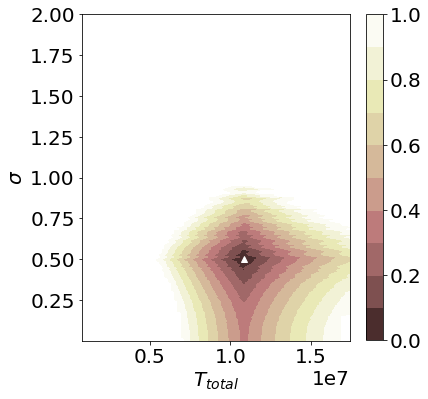

In [327]:
ii=0
plot_grid(TT_set, sigma_set, roulette_grids[ii], data_roulette.prop_poly[ii], data_roulette.ratio_est[ii])

(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:xlabel='$T_{total}$', ylabel='$\\sigma$'>)

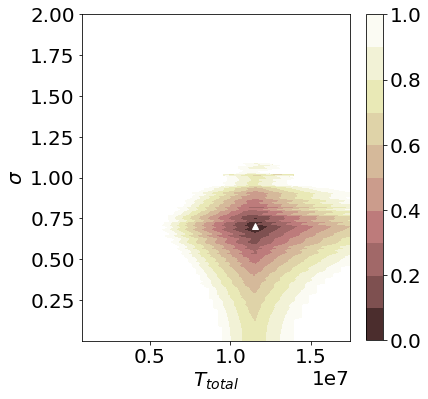

In [328]:
ii=0
plot_grid(TT_set, sigma_set, carlson_grids[ii], data_carlson.prop_poly[ii], data_carlson.ratio_est[ii])

(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:xlabel='$T_{total}$', ylabel='$\\sigma$'>)

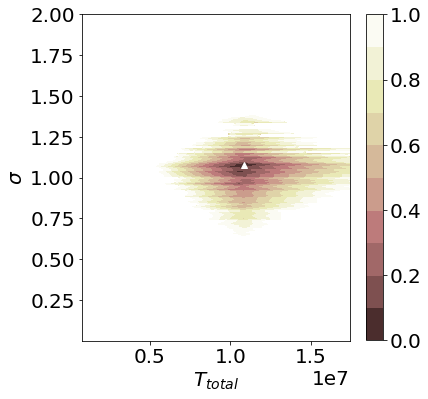

In [329]:
ii=0
plot_grid(TT_set, sigma_set, gnomad_grids[ii], data_gnomad.prop_poly[ii], data_gnomad.ratio_est[ii])

In [443]:
TT_est_roulette = np.array([min_sigma_TT(TT_set, sigma_set, roulette_grids[ii], data_roulette.prop_poly[ii], data_roulette.ratio_est[ii])[0] 
                            for ii in range(len(roulette_grids))])
sigma_est_roulette = np.array([min_sigma_TT(TT_set, sigma_set, roulette_grids[ii], data_roulette.prop_poly[ii], data_roulette.ratio_est[ii])[1] 
                      for ii in range(len(roulette_grids))])
data_roulette["TT_est"] = TT_est_roulette
data_roulette["sigma_est"] = sigma_est_roulette
data_roulette["var_est"] = (np.exp(sigma_est_roulette**2)-1)*(data_roulette.mu_est*mu_scale)**2

TT_est_carlson = np.array([min_sigma_TT(TT_set, sigma_set, carlson_grids[ii], data_carlson.prop_poly[ii], data_carlson.ratio_est[ii])[0] 
                           for ii in range(len(carlson_grids))])
sigma_est_carlson = np.array([min_sigma_TT(TT_set, sigma_set, carlson_grids[ii], data_carlson.prop_poly[ii], data_carlson.ratio_est[ii])[1] 
                              for ii in range(len(carlson_grids))])
data_carlson["TT_est"] = TT_est_carlson
data_carlson["sigma_est"] = sigma_est_carlson
data_carlson["var_est"] = (np.exp(sigma_est_carlson**2)-1)*(data_carlson.mu_est*mu_scale)**2

TT_est_gnomad = np.array([min_sigma_TT(TT_set, sigma_set, gnomad_grids[ii], data_gnomad.prop_poly[ii], data_gnomad.ratio_est[ii])[0] 
                          for ii in range(len(gnomad_grids))])
sigma_est_gnomad = np.array([min_sigma_TT(TT_set, sigma_set, gnomad_grids[ii], data_gnomad.prop_poly[ii], data_gnomad.ratio_est[ii])[1] 
                             for ii in range(len(gnomad_grids))])
data_gnomad["TT_est"] = TT_est_gnomad
data_gnomad["sigma_est"] = sigma_est_gnomad
data_gnomad["var_est"] = (np.exp(sigma_est_gnomad**2)-1)*(data_gnomad.mu_est*mu_scale)**2

Text(0, 0.5, '$T_{total}$')

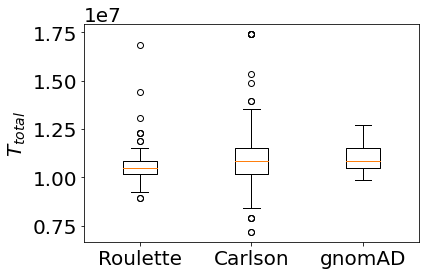

In [444]:
plt.boxplot((TT_est_roulette, TT_est_carlson, TT_est_gnomad), 
            labels=["Roulette", "Carlson", "gnomAD"]);
plt.ylabel(r"$T_{total}$")

There is some variation in the estimated $T_{\text{total}}$ but the spread is actually pretty reasonable.

In [445]:
def plot_sigma(data_mut, ax, color="black", alpha=0.8, alpha_ebar=0.3, label=None, mu_scale=mu_scale):
    ax.scatter(data_mut.mu_est*mu_scale, data_mut.sigma_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.sigma_est, 
                xerr=[data_mut.mu_est*mu_scale - data_mut.mu_95CI_lower*mu_scale, 
                      data_mut.mu_95CI_upper*mu_scale - data_mut.mu_est*mu_scale], fmt="none", color=color, alpha=alpha_ebar)
    
def plot_var(data_mut, ax, color="black", alpha=0.8, alpha_ebar=0.3, label=None, mu_scale=mu_scale):
    ax.scatter(data_mut.mu_est*mu_scale, data_mut.var_est, color=color, alpha=alpha, label=label)
    ax.errorbar(data_mut.mu_est*mu_scale, data_mut.var_est, 
                xerr=[data_mut.mu_est*mu_scale - data_mut.mu_95CI_lower*mu_scale, 
                      data_mut.mu_95CI_upper*mu_scale - data_mut.mu_est*mu_scale], fmt="none", color=color, alpha=alpha_ebar)

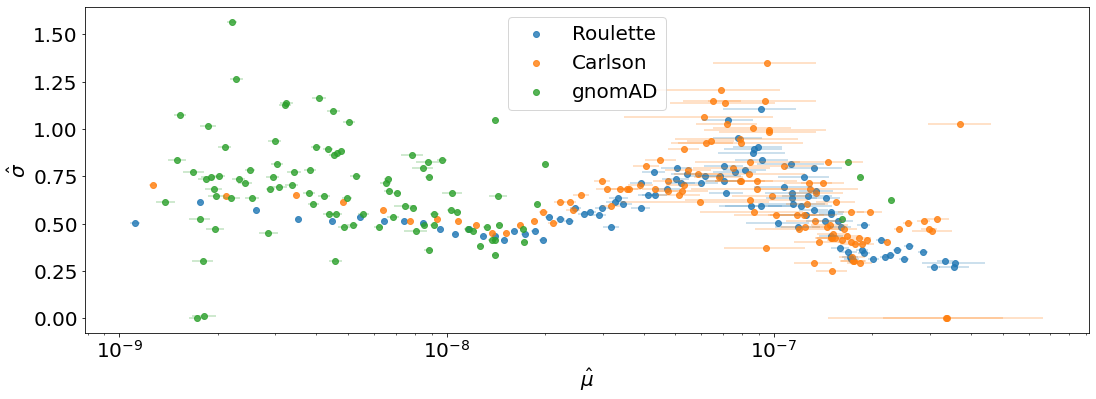

In [446]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_sigma(data_roulette, ax, color=c_roulette, label="Roulette")
plot_sigma(data_carlson, ax, color=c_carlson, label="Carlson")
plot_sigma(data_gnomad, ax, color=c_gnomad, label="gnomAD")

ax.set_xscale("log")
ax.set_ylabel(r"$\hat{\sigma}$")
ax.set_xlabel(r"$\hat{\mu}$")

ax.legend(loc="upper center")

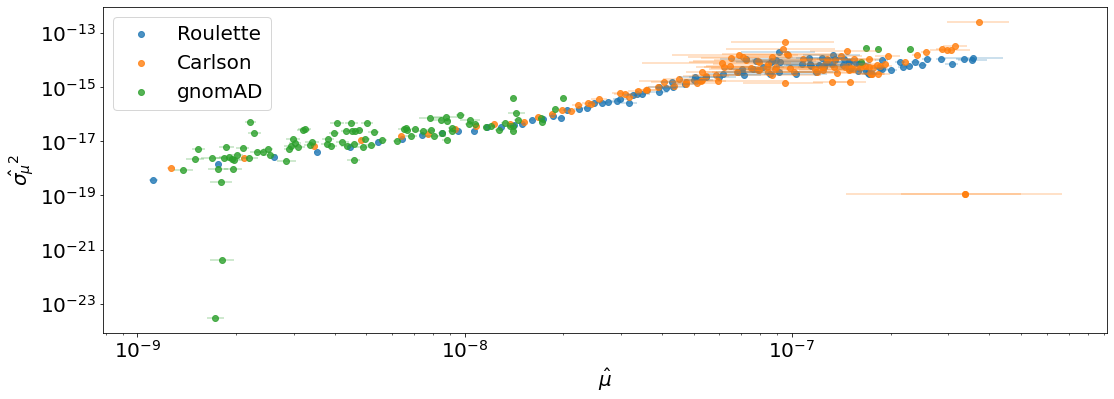

In [498]:
fig, ax = plt.subplots(figsize=(18, 6))
plot_var(data_roulette, ax, color=c_roulette, label="Roulette")
plot_var(data_carlson, ax, color=c_carlson, label="Carlson")
plot_var(data_gnomad, ax, color=c_gnomad, label="gnomAD")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\hat{\sigma_{\mu}}^2$")
ax.set_xlabel(r"$\hat{\mu}$")

ax.legend(loc="upper left")

The actual variance itself mostly just scales with mutation rate. This makes sense because multiplicative changes in mutation rate have a much larger effect on the overall variance at sites with higher mutation rates. To get a sense for the total amount of residual variation in the different models we should sum the variance across bins.

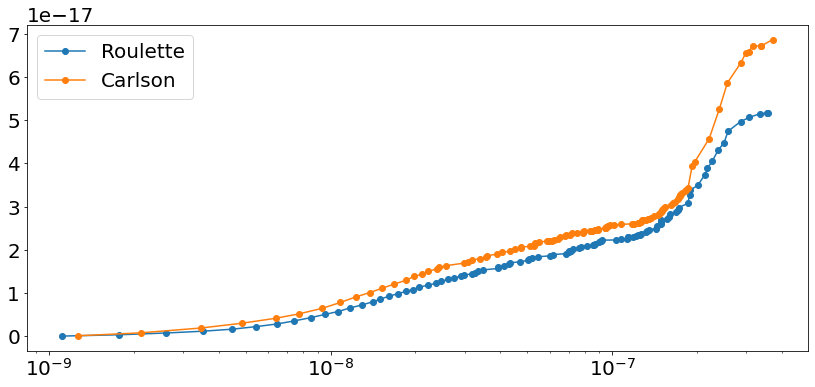

In [448]:
fig, ax = plt.subplots(figsize=(14, 6))

roulette_order = np.argsort(data_roulette.mu_est)
carlson_order = np.argsort(data_carlson.mu_est)
cvar_roulette = np.cumsum(data_roulette.prop_sites[roulette_order] * data_roulette.var_est[roulette_order])
cvar_carlson = np.cumsum(data_carlson.prop_sites[carlson_order] * data_carlson.var_est[carlson_order])
plt.plot(data_roulette.mu_est[roulette_order] * mu_scale, cvar_roulette, "-o", color=c_roulette, label="Roulette")
plt.plot(data_carlson.mu_est[carlson_order] * mu_scale, cvar_carlson, "-o", color=c_carlson, label="Carlson")
plt.xscale("log")
plt.legend(loc="upper left")

In [466]:
roulette_mean = np.sum(data_roulette.prop_sites*data_roulette.mu_est*mu_scale)
roulette_bin_var = np.sum(data_roulette.prop_sites*(roulette_mean - data_roulette.mu_est*mu_scale)**2)

carlson_mean = np.sum(data_carlson.prop_sites*data_carlson.mu_est*mu_scale)
carlson_bin_var = np.sum(data_carlson.prop_sites*(carlson_mean - data_carlson.mu_est*mu_scale)**2)

gnomad_mean = np.sum(data_gnomad.prop_sites*data_gnomad.mu_est*mu_scale)
gnomad_bin_var = np.sum(data_gnomad.prop_sites*(gnomad_mean - data_gnomad.mu_est*mu_scale)**2)

roulette_res_var = np.sum(data_roulette.prop_sites*data_roulette.var_est)
print(roulette_res_var, roulette_bin_var)

carlson_res_var = np.sum(data_carlson.prop_sites*data_carlson.var_est)
print(carlson_res_var, carlson_bin_var)

gnomad_res_var = np.sum(data_gnomad.prop_sites*data_gnomad.var_est)
print(gnomad_res_var, gnomad_bin_var)

print(roulette_res_var/(roulette_res_var + roulette_bin_var), carlson_res_var/(carlson_res_var + carlson_bin_var),  gnomad_res_var/(gnomad_res_var + gnomad_bin_var))
print(roulette_res_var/(roulette_res_var + roulette_bin_var), carlson_res_var/(roulette_res_var + roulette_bin_var),  gnomad_res_var/(roulette_res_var + roulette_bin_var))


5.175395871688939e-17 2.2078630657262277e-16
6.869073032740801e-17 1.9840078388740666e-16
1.3949484308915331e-16 1.8476297302523185e-16
0.18989472495710882 0.2571805043276735 0.43019731879013556
0.18989472495710882 0.252038832700334 0.5118320514620902


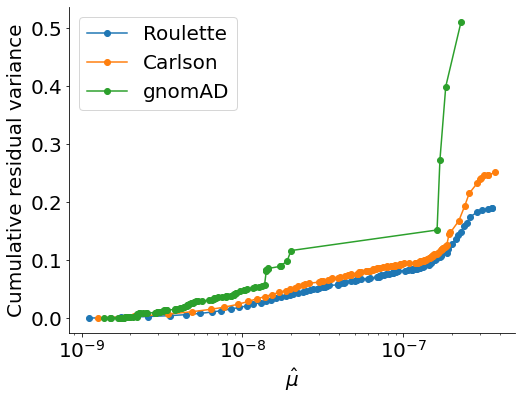

In [507]:
fig, ax = plt.subplots(figsize=(8, 6))

roulette_order = np.argsort(data_roulette.mu_est)
carlson_order = np.argsort(data_carlson.mu_est)
gnomad_order = np.argsort(data_gnomad.mu_est)

cvar_roulette = np.cumsum(data_roulette.prop_sites[roulette_order] * data_roulette.var_est[roulette_order])
cvar_carlson = np.cumsum(data_carlson.prop_sites[carlson_order] * data_carlson.var_est[carlson_order])
cvar_gnomad = np.cumsum(data_gnomad.prop_sites[gnomad_order] * data_gnomad.var_est[gnomad_order])

plt.plot(data_roulette.mu_est[roulette_order] * mu_scale, 
         cvar_roulette/(roulette_res_var + roulette_bin_var), "-o", color=c_roulette, label="Roulette")
plt.plot(data_carlson.mu_est[carlson_order] * mu_scale, 
         cvar_carlson/(roulette_res_var + roulette_bin_var), "-o", color=c_carlson, label="Carlson")
plt.plot(data_gnomad.mu_est[gnomad_order] * mu_scale, 
         cvar_gnomad/(roulette_res_var + roulette_bin_var), "-o", color=c_gnomad, label="gnomAD")
plt.xscale("log")
plt.legend(loc="upper left")
plt.ylabel("Cumulative residual variance")
plt.xlabel(r"$\hat{\mu}$")
#plt.yscale("log")

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
simpleaxis(ax)

fig.savefig("residual_variance_cumulative_w_gnomad.pdf", bbox_inches="tight")

In [503]:
np.sum(data_roulette.prop_sites * data_roulette.ratio_est), np.sum(data_carlson.prop_sites * data_carlson.ratio_est), np.sum(data_gnomad.prop_sites * data_gnomad.ratio_est)

(1.335710409575579, 1.4694668437217815, 1.9424907828137326)

On average, mutations with SNVs in the polymorphism data were 1.33 times more likely to have a de novo observation, is pretty substantial.

Text(0, 0.5, 'de novo ratio')

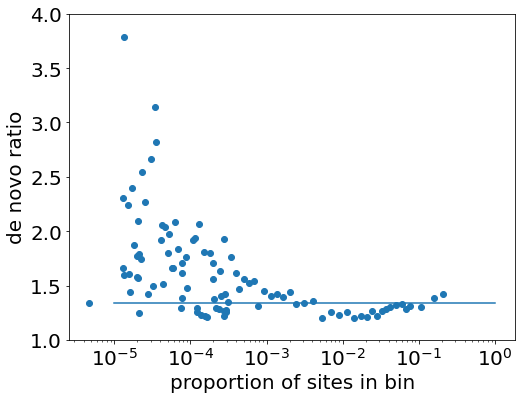

In [454]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data_roulette.prop_sites, data_roulette.ratio_est);
plt.plot([1e-5, 1], [np.sum(data_roulette.prop_sites * data_roulette.ratio_est)]*2)
plt.xscale("log")
plt.ylim([1, 4])
plt.xlabel("proportion of sites in bin")
plt.ylabel("de novo ratio")